## Imports

### Install packages

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [2]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet graphviz)"

In [3]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet dataframe_image)"

### Import modules

In [4]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
dir_name = "./Lesson07-data"

!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


In [6]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux ef783958e0e8 6.10.14-linuxkit #1 SMP Tue Apr 15 16:00:54 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.3
arviz version=0.21.0
preliz version=0.19.0


# Chemical Shift

## Gaussian inference

48 [51.06 55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43
 53.   56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58
 51.36 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82
 54.99 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


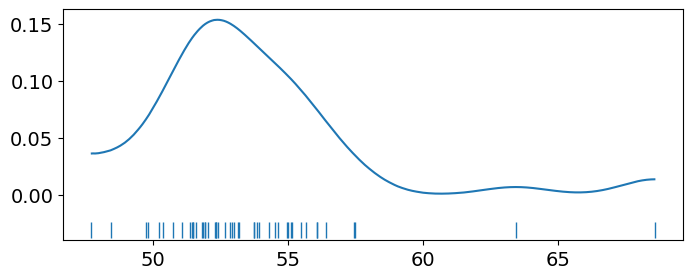

In [7]:
data = np.loadtxt(f"{dir_name}/chemical_shifts.csv")
print(len(data), data)
#print(sorted(data))

# It looks Gaussian with a couple of outliers.
az.plot_kde(data, rug=True)

title = "Chemical shift"
ut.process_figure(title);

In [8]:
with pm.Model() as model_g:
    # The mean is Uniform in [40, 70] (which is larger than the data).
    mu = pm.Uniform("mu", lower=40, upper=70)
    # The std dev is half normal with a large value (which is a large value based on the data).
    sigma = pm.HalfNormal("sigma", sigma=10)
    # The model is N(mu, sigma).
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sample.
    idata_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


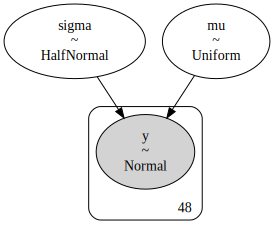

In [9]:
pm.model_to_graphviz(model_g)

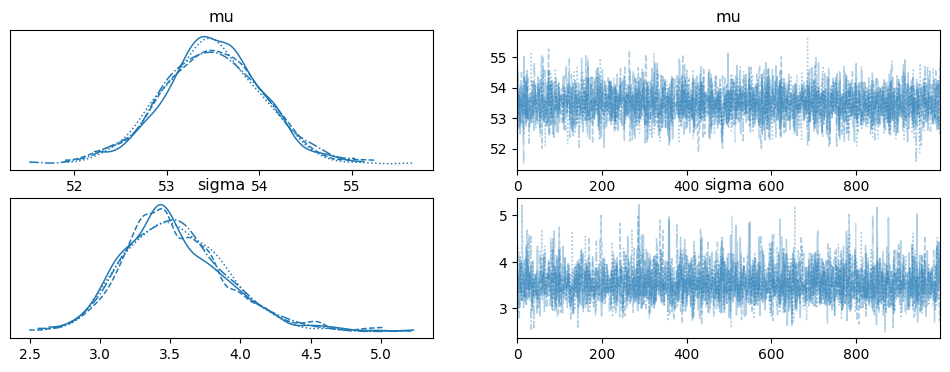

In [10]:
# There are 4 traces for 2 variables.
az.plot_trace(idata_g);

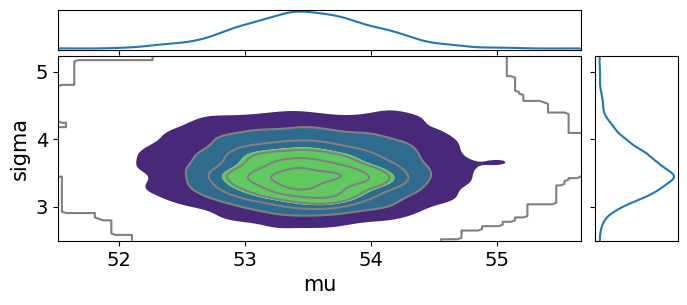

In [11]:
# The posterior distribution of the params is bi-dimensional, since it has mu and sigma.
az.plot_pair(idata_g, kind='kde', marginals=True);

In [12]:
# Report a summary of the inference.
az.summary(idata_g, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,53.49,0.53,52.48,54.47
sigma,3.54,0.37,2.89,4.24


In [13]:
# Compute 100 posterior predictive samples.
y_pred_g = pm.sample_posterior_predictive(idata_g, model=model_g)

Sampling: [y]


Output()

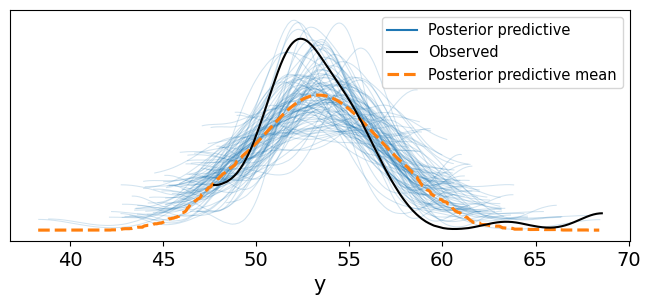

In [14]:
# Black: KDE of the data (observed)
# Blue: KDEs of the posterior predictive samples
# Orange: KDE of the posterior predictive mean
az.plot_ppc(y_pred_g, mean=True, num_pp_samples=100);

## Student-t

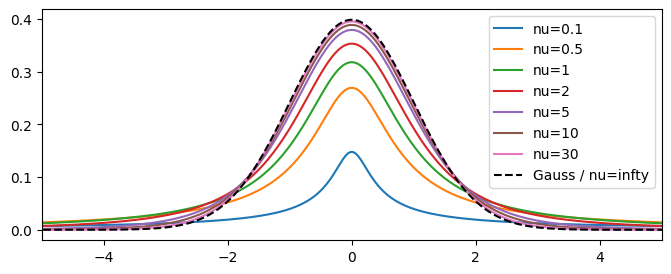

In [15]:
# Show the PDF for various values of \nu.

# Points to be used to sample the PDF.
x_values = np.linspace(-10, 10, 500)

# Plot t-student sweeping \nu.
for df in [0.1, 0.5, 1, 2, 5, 10, 30]:
    # Student-t with df.
    distr = stats.t(df)
    # Compute PDF.
    x_pdf = distr.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f"nu={df}")
    
# Plot gaussian.
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, "k--", label="Gauss / nu=infty")

plt.xlim(-5, 5) 
plt.legend();

title = "Chap7: Student-t"
ut.process_figure(title);

In [16]:
# Use a Student-T model.
with pm.Model() as model_t:
    mu = pm.Uniform("mu", 40, 75)
    sigma = pm.HalfNormal("sigma", sigma=10)
    # A student with nu = 30 is close to a Gaussian.
    nu = pm.Exponential("nu", 1/30)
    #
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=data)
    idata_t = pm.sample(1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


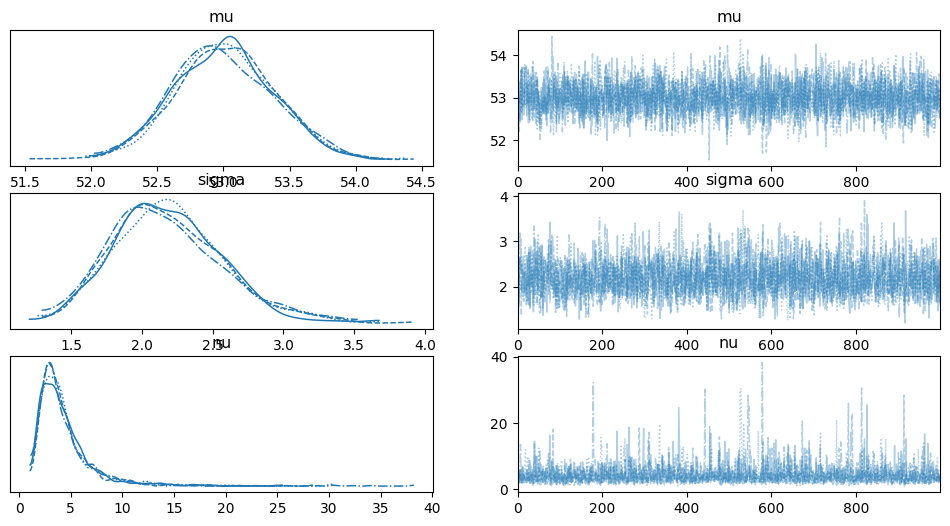

In [17]:
az.plot_trace(idata_t);

In [18]:
az.summary(idata_t, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,53.01,0.38,52.34,53.75
sigma,2.18,0.39,1.45,2.88
nu,4.40,3.00,1.05,8.90


In [19]:
# Compute 100 posterior predictive samples.
y_ppc_t = pm.sample_posterior_predictive(idata_t, model_t);

Sampling: [y]


Output()

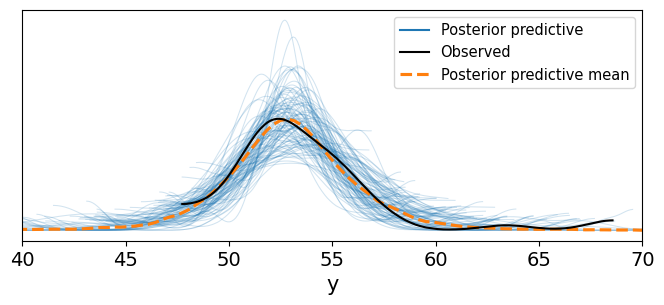

In [20]:
ax = az.plot_ppc(y_ppc_t, num_pp_samples=100, mean=True)
ax.set_xlim(40, 70);